In [4]:
import pandas as pd
import numpy as np
import os
import datetime
today = datetime.datetime.now().strftime("%Y%m%d")

# create a word cloud from the review comments
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mtick
import string
import re
import os
import pandas as pd
import numpy as np
import spacy
import gc
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

In [5]:
graphicfolder = "./figures"
if not os.path.exists(graphicfolder):
    os.makedirs(graphicfolder)

# Goal: use simple statistics based NLP methods to analyze the paper published recently
* Learn simple usage of NLTK python package
* understand the PMI (pointwise mutual information) score
## Method:
1. Download all article abstracts from Webofscience: 1900 + articles
2. Visualize the temporal trend
3. Visualize the field categories


In [1]:
# Run these below to install the library and packages
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg
!pip install spacy
!pip install wordcloud
!pip install nltk

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 217.9 kB/s eta 0:00:59
     --------------------------------------- 0.1/12.8 MB 465.5 kB/s eta 0:00:28
     --------------------------------------- 0.1/12.8 MB 774.0 kB/s eta 0:00:17
      --------------------------------------- 0.2/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.4/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.6/12.8 MB 2.1 MB/s eta 0:00:06
     --- ------------------------------------ 1.1/12.8 MB 3.0 MB/s eta 0:00:04
     ----- ---------------------------------- 1.7/12.8 MB 4.1 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 5.0 MB/s eta 0:00:03
     -------- ------------------------------- 2.8/12.8 MB 5.5 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 6.2 M

In [2]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yuanzfan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
# load the data
DF = pd.read_csv('data/abstracts-machine learning urban planning-20231203-1932rows.csv', index_col=0)
DF = DF[~DF['Abstract'].isna()].reset_index(drop = True)

## 1. Tokenize the text

In [13]:
#extract only reviews
en_stopwords = set(stopwords.words('english'))
def get_one_class(DF):
    # value is a list
    comments = DF['Abstract']
    comments = comments.astype('str')
    
    #function to remove non-ascii characters
    def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)
    #remove non-ascii characters
    comments = comments.map(lambda x: _removeNonAscii(x))
    print(comments.shape[0])
    #get stop words of all languages
    STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}
    #function to detect language based on # of stop words for particular language
    def get_language(text):
        words = set(nltk.wordpunct_tokenize(text.lower()))
        lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
        if lang == 'english':
            return True
        else:
            return False
        
    return comments

def get_tokens(eng_comments):
    #load spacy
    nlp = spacy.load("en_core_web_sm")

    #function to clean and lemmatize comments
    def clean_comments(text):
        #remove punctuations
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        nopunct = regex.sub(" ", str(text))
        #use spacy to lemmatize comments
        doc = nlp(nopunct, disable=['parser','ner'])
        lemma = [token.lemma_ for token in doc]
        return lemma

    #apply function to clean and lemmatize comments
    lemmatized = eng_comments.map(clean_comments)

    #make sure to lowercase everything
    lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

    #turn all comments' tokens into one single list
    unlist_comments = [item for items in lemmatized for item in items]
    return lemmatized, unlist_comments

def rightTypes(ngram, en_stopwords = en_stopwords):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
    
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False



## 2. Create PMI for biagram

1. What is PMI? [SOURCE](https://medium.com/@bekirufuk/creating-a-pmi-dictionary-for-multiple-documents-using-nltk-b3be4bf31f8e).

PMI metric depends on occurrences of words (or events in a more general sense) by themselves and co-occurrences with others. It is represented by the simple formula below.
<p align="center">
<img src="../asset/PMI.webp" alt="pmi" style="width:50%; border:0;">
</p>
While w1 and w2 represent the two words that we see the PMI score of, P(w1) and P(w2) represent their frequencies throughout the corpus, and P(w1, w2) represents the frequency of their co-occurrence.
Then we multiply the PMI and frequency for each bigram to compute a normalized density score.

In [ ]:
def get_word_rank(DF, 
                  en_stopwords = en_stopwords):
    comments = get_one_class(DF)
    _, unlist_comments = get_tokens(comments)
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_comments)

    #bigrams
    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    #trigrams
    trigram_freq = trigramFinder.ngram_fd.items()
    trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x, en_stopwords))]
    # filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x, en_stopwords))]
    
    #filter for only those with more than 20 occurences
    bigramFinder.apply_freq_filter(20)
    # trigramFinder.apply_freq_filter(20)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                                columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    # trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), 
    #                             columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)
    # merge the bigramPMITable and big
    mergedbig = filtered_bi.merge(bigramPMITable, on = 'bigram', how = 'inner')
    mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
    mergedbig = mergedbig.sort_values(by = 'freqxPMI', ascending = False)
    
    # merge the trigramPMITable and trig
    # mergedtri = filtered_tri.merge(trigramPMITable, on = 'trigram', how = 'inner')
    # mergedtri['freqxPMI'] = mergedtri['freq'] * mergedtri['PMI']
    # mergedtri = mergedtri.sort_values(by = 'freqxPMI', ascending = False)
    return mergedbig
# , mergedtri

In [30]:
mergedbig= get_word_rank(DF)

1931


In [51]:
drop1 = [
    "deep learning",
    "machine learning",
    "machine learn",
    "neural network",
    "artificial intelligence",
    "artificial neural",
    "support vector",
    "e g",
    "natural language",
    "result show",
    "gradient boost",
    "result indicate",
    "vector machine",
    "decision tree",
    "mean square",
    "square root",
    "r squre",
    "mean absolut",
    "b v",
    "elsevi b",
    "square error",
    "root mean",
    "learn algorithm",
    "learn technique",
]

In [52]:
dropwords = drop1.copy()
mergedbig['text'] = mergedbig['bigram'].map(lambda x: ' '.join(x))
mergedbig_update = mergedbig[mergedbig['text'].isin(dropwords) == False].reset_index(drop =True)
# mergedbig_update = mergedbig.copy()
taskdict = dict(zip(mergedbig_update['text'], mergedbig_update['freqxPMI']))

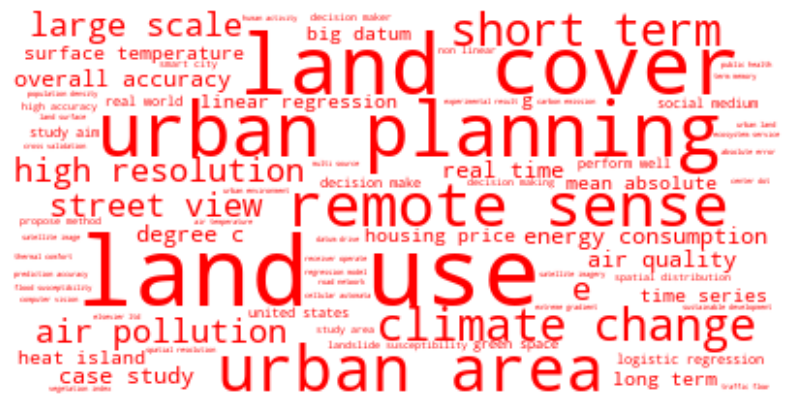

In [53]:
# create wordcloud using the taskdict
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white",
                      prefer_horizontal=1, 
                      # change color_func to change the color of the word cloud
                        color_func=lambda *args, **kwargs: "red"
                      )
wordcloud.fit_words(taskdict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Course work:
Only use trigram to reconduct the analysis